<a href="https://colab.research.google.com/github/A3Lab-UNIVPM/DL4SP_notebooks/blob/main/Attention_NILM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ATTENTION-NILM

This notebook reproduces the work published by Piccialli et al. 2020 for load disaggregation. 
The notebook structure is the following:
 

1.   Libraries import and class definition
2.   Network definition
3.   Metrics definition 
4.   Data loading and pre-processing 
5.   Network training
6.   Network inference and test scores



In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt 
from tensorflow.python.keras.utils.data_utils import Sequence
import tensorflow.keras as keras
import pandas as pd
import os

tf.random.set_seed(7)

## Definition of DataGenerator class

This class derives from keras Sequence used to iterate over the data and create signal windows disjointed or overlapped. 

The class creates the batch containing the windows of aggregate and both target sequences (one for classification and one for disaggregation) to be passed to the network.

Number of windows considered in the batch depends on the batch size, defined subsequently. 

In [2]:
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, mains, appliances_regression, appliances_classification, window_size, batch_size, shuffle=False):
        self.mains = mains
        self.appliances_regression = appliances_regression
        self.appliances_classification = appliances_classification
        self.window_size = window_size
        self.batch_size = batch_size
        self.indices = np.arange(len(self.mains) - self.window_size + 1)
        self.shuffle = shuffle

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))  

    def __getitem__(self, idx):
        mains_batch = []
        appliances_regression_batch = []
        appliances_classification_batch = []
        appliance_regression_sample = []
        appliance_classification_sample = []

        if idx == self.__len__() - 1:
            inds = self.indices[idx * self.batch_size:]
        else:
            inds = self.indices[idx * self.batch_size: (idx + 1) * self.batch_size]

        for i in inds:
            main_sample = self.mains[i:i + self.window_size]
            appliance_regression_sample = self.appliances_regression[i:i + self.window_size]
            appliance_classification_sample = self.appliances_classification[i:i + self.window_size]

            mains_batch.append(main_sample)
            appliances_regression_batch.append(appliance_regression_sample)
            appliances_classification_batch.append(appliance_classification_sample)

        mains_batch_np = np.array(mains_batch)
        mains_batch_np = np.reshape(mains_batch_np, (mains_batch_np.shape[0], mains_batch_np.shape[1], 1))
        appliances_regression_batch_np = np.array(appliances_regression_batch)
        appliances_regression_batch_np = np.reshape(appliances_regression_batch_np,
                                                    (appliances_regression_batch_np.shape[0],
                                                     appliances_regression_batch_np.shape[1]))
        appliances_classification_batch_np = np.array(appliances_classification_batch)
        appliances_classification_batch_np = np.reshape(appliances_classification_batch_np,
                                                        (appliances_classification_batch_np.shape[0],
                                                         appliances_classification_batch_np.shape[1]))

        return mains_batch_np, [appliances_regression_batch_np, appliances_classification_batch_np]

    def on_epoch_end(self):

        if self.shuffle:
            np.random.shuffle(self.indices)



## Definition of network structure and AttentionLayer class

Definition of the attention layer as a keras model and network creation.

The network is composed of one regression branch and one classification branch. Outputs are multiplied and the loss is computed on the final output.


In [3]:
class AttentionLayer(tf.keras.Model):

    def __init__(self, units):
        super(AttentionLayer, self).__init__()
        weight_initializer = 'he_normal'
        self.W = tf.keras.layers.Dense(units, kernel_initializer=weight_initializer)
        self.V = tf.keras.layers.Dense(1, kernel_initializer=weight_initializer)

    def call(self, encoder_output, **kwargs):
        # encoder_output shape == (batch_size, seq_length, latent_dim)
        # score shape == (batch_size, seq_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, seq_length, units)
        score = self.V(tf.nn.tanh(self.W(encoder_output)))

        # attention_weights shape == (batch_size, seq_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * encoder_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

def build_model(window_size, filters, kernel_size, units):
    input_data = tf.keras.Input(shape=(window_size, 1))

    # CLASSIFICATION SUBNETWORK
    x = tf.keras.layers.Conv1D(filters=30, kernel_size=10, activation='relu')(input_data)
    x = tf.keras.layers.Conv1D(filters=30, kernel_size=8, activation='relu')(x)
    x = tf.keras.layers.Conv1D(filters=40, kernel_size=6, activation='relu')(x)
    x = tf.keras.layers.Conv1D(filters=50, kernel_size=5, activation='relu')(x)
    x = tf.keras.layers.Conv1D(filters=50, kernel_size=5, activation='relu')(x)
    x = tf.keras.layers.Conv1D(filters=50, kernel_size=5, activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(units=1024, activation='relu', kernel_initializer='he_normal')(x)
    classification_output = tf.keras.layers.Dense(units=window_size, activation='sigmoid', name="classification_output")(x)

    #REGRESSION SUBNETWORK
    y = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(input_data)
    y = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(y)
    y = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(y)
    y = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(y)
    y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units, activation="tanh", return_sequences=True), merge_mode="concat")(y)
    y, weights = AttentionLayer(units=units)(y)
    y = tf.keras.layers.Dense(units, activation='relu')(y)
    regression_output = tf.keras.layers.Dense(window_size, activation='relu', name="regression_output")(y)

    output = tf.keras.layers.Multiply(name="output")([regression_output, classification_output])

    full_model = tf.keras.Model(inputs=input_data, outputs=[output, classification_output], name="LDwA")
    attention_model = tf.keras.Model(inputs=input_data, outputs=weights)

    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)   

    full_model.compile(optimizer=optimizer, loss={
        "output": tf.keras.losses.MeanSquaredError(),
        "classification_output": tf.keras.losses.BinaryCrossentropy()}, metrics= ["mae"])


    return full_model, attention_model

This function is defined to reconstruct the original sequence after the windowing. 

In [4]:
def build_overall_sequence(sequences):
    unique_sequence = []
    matrix = [sequences[::-1, :].diagonal(i) for i in range(-sequences.shape[0] + 1, sequences.shape[1])]
    for i in range(len(matrix)):
        unique_sequence.append(np.median(matrix[i]))
    unique_sequence = np.array(unique_sequence)
    return unique_sequence


## Metrics

Definition of metrics for performance evaluation.


In [5]:
# METRICS FOR PERFORMANCE EVALUATION
def mae(prediction, true):
    MAE = abs(true - prediction)
    MAE = np.sum(MAE)
    MAE = MAE / len(prediction)
    return MAE


def sae(prediction, true, N):
    T = len(prediction)
    K = int(T / N)
    SAE = 0
    for k in range(1, N):
        pred_r = np.sum(prediction[k * N: (k + 1) * N])
        true_r = np.sum(true[k * N: (k + 1) * N])
        SAE += abs(true_r - pred_r)
    SAE = SAE / (K * N)
    return SAE


def f1(prediction, true):
    epsilon = 1e-8
    TP = epsilon
    FN = epsilon
    FP = epsilon
    TN = epsilon
    for i in range(len(prediction)):
        if prediction[i] >= 0.5:
            prediction_binary = 1
        else:
            prediction_binary = 0
        if prediction_binary == 1 and true[i] == 1:
            TP += 1
        elif prediction_binary == 0 and true[i] == 1:
            FN += 1
        elif prediction_binary == 1 and true[i] == 0:
            FP += 1
        elif prediction_binary == 0 and true[i] == 0:
            TN += 1
    R = TP / (TP + FN)
    P = TP / (TP + FP)
    f1 = (2 * P * R) / (P + R)
    return f1

## Data pre-processing functions definition

In [6]:
def standardize_data(data, mu=0.0, sigma=1.0):
    data -= mu
    data /= sigma
    return data


def normalize_data(data, min_value=0.0, max_value=1.0):
    data -= min_value
    data /= max_value - min_value
    return data

## Data Loading and pre-processing

Training, validation and test sets are loaded and pre-processed.

The aggregate signals are standardize while the regression output is normalized. The classification target vector is binarized to be feed into the network with a threshold of 15 Watt for each appliance.

In [7]:
# download data
!wget -nc -O NILM_data.zip "https://drive.google.com/uc?export=download&id=1_snmZnFDqfKJeQdCzIwjaDere8quPYZB"
!unzip -q NILM_data.zip

--2021-12-31 16:50:04--  https://drive.google.com/uc?export=download&id=1_snmZnFDqfKJeQdCzIwjaDere8quPYZB
Resolving drive.google.com (drive.google.com)... 108.177.125.138, 108.177.125.100, 108.177.125.101, ...
Connecting to drive.google.com (drive.google.com)|108.177.125.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7tfl95boa6gits8vld7a6op5a8sedv0d/1640969400000/03236194938607487210/*/1_snmZnFDqfKJeQdCzIwjaDere8quPYZB?e=download [following]
--2021-12-31 16:50:06--  https://doc-0g-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7tfl95boa6gits8vld7a6op5a8sedv0d/1640969400000/03236194938607487210/*/1_snmZnFDqfKJeQdCzIwjaDere8quPYZB?e=download
Resolving doc-0g-9c-docs.googleusercontent.com (doc-0g-9c-docs.googleusercontent.com)... 64.233.189.132, 2404:6800:4008:c07::84
Connecting to doc-0g-9c-docs.googleusercontent.com (do

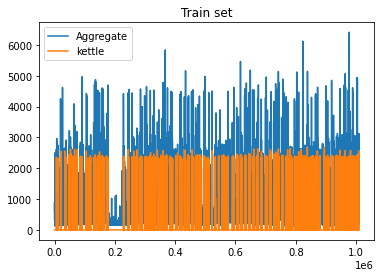

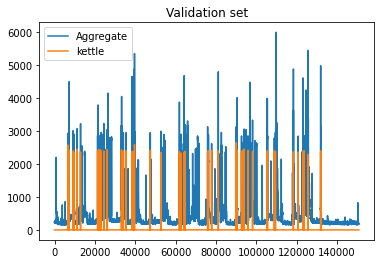

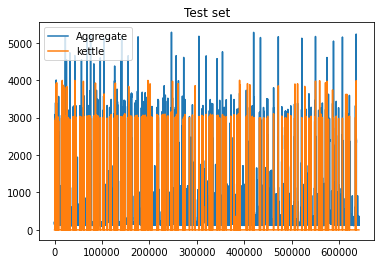

In [12]:
# Read the NILM dataset

appliance = 'kettle'
plot = True

val_data = np.array(pd.read_csv(os.path.join(appliance, appliance + '_validation_.csv')))
train_data = np.array(pd.read_csv(os.path.join(appliance, appliance + '_training_.csv')))
test_data = np.array(pd.read_csv(os.path.join(appliance, appliance + '_test_.csv'), skiprows=1500000))

main_train, appliance_train = train_data[:,0], train_data[:,1]
main_val, appliance_val = val_data[:,0], val_data[:,1]
main_test, appliance_test = test_data[:,0], test_data[:,1]
      
if plot:
        
        plt.plot(main_train)
        plt.plot(appliance_train)
        plt.legend(['Aggregate', appliance], loc='upper left')
        plt.title("Train set")
        plt.show()
        plt.plot(main_val)
        plt.plot(appliance_val)
        plt.legend(['Aggregate', appliance], loc='upper left')
        plt.title("Validation set")
        plt.show()
        plt.plot(main_test)
        plt.plot(appliance_test)
        plt.legend(['Aggregate', appliance], loc='upper left')
        plt.title("Test set")
        plt.show()
      
# Threshold of 15 Watt for detecting the ON/OFF states
      
THRESHOLD = 15
appliance_train_classification = np.copy(appliance_train)
appliance_train_classification[appliance_train_classification <= THRESHOLD] = 0
appliance_train_classification[appliance_train_classification > THRESHOLD] = 1

appliance_val_classification = np.copy(appliance_val)
appliance_val_classification[appliance_val_classification <= THRESHOLD] = 0
appliance_val_classification[appliance_val_classification > THRESHOLD] = 1

# Standardization of the main power and normalization of appliance power
appliance_min_power = np.min(appliance_train)
appliance_max_power = np.max(appliance_train)
main_std = np.std(main_train)
main_mean = np.mean(main_train)

main_train = standardize_data(main_train, np.mean(main_train), np.std(main_train))
main_val = standardize_data(main_val, np.mean(main_val), np.std(main_val))

appliance_train_regression = np.copy(appliance_train)
appliance_train_regression = normalize_data(appliance_train_regression, appliance_min_power, appliance_max_power)

appliance_val_regression = np.copy(appliance_val)
appliance_val_regression = normalize_data(appliance_val_regression, appliance_min_power, appliance_max_power)
   

## Network Training

Firstly, the window dimension and the hyperparameters have to be selected based on the desired appliance. 

Then, the model was built and trained monitoring the validation loss.  

Model: "LDwA"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 119, 30)      330         ['input_1[0][0]']                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 125, 32)      160         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 112, 30)      7230        ['conv1d[0][0]']                 
                                                                                               

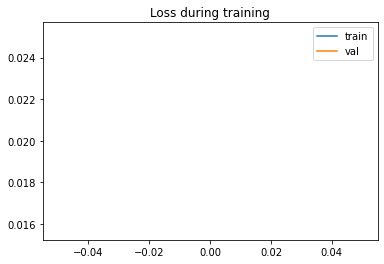

INFO:tensorflow:Assets written to: /content/kettle_weights/assets


INFO:tensorflow:Assets written to: /content/kettle_weights/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


<Figure size 432x288 with 0 Axes>

In [13]:
# Choose the appliance-specific window size and hyperparms 
window_size = 0
   
if appliance == 'kettle':
        window_size = 128
        filters = 32
        kernel_size = 4 
        units = 128
if appliance == 'microwave':
        window_size = 256
        filters = 32
        kernel_size = 4 
        units = 256
if appliance == 'fridge':
        window_size = 512
        filters = 32
        kernel_size = 8 
        units = 256
if appliance == 'dishwasher':
        window_size = 1024
        filters = 64
        kernel_size = 16 
        units = 256
if appliance == 'washingmachine':
        window_size = 1536
        filters = 16
        kernel_size = 4
        units = 512

   
# Dataset generator
batch_size = 32
train_generator = DataGenerator(main_train, appliance_train_regression,
                                    appliance_train_classification, window_size, batch_size)
val_generator = DataGenerator(main_val, appliance_val_regression,
                                  appliance_val_classification, window_size, batch_size)

train_steps = train_generator.__len__()
validation_steps = val_generator.__len__()
   
model, att_model = build_model(window_size, filters, kernel_size, units)
model.summary()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(x=train_generator, epochs=1, steps_per_epoch=train_steps,   #100   
                        validation_data=val_generator, validation_steps=validation_steps,
                       callbacks=[early_stop], verbose=1)
     
# Plotting the results of training
    
history_dict = history.history
plt.title('Loss during training')
plt.plot(np.arange(len(history.epoch)), history_dict['loss'])
plt.plot(np.arange(len(history.epoch)), history_dict['val_loss'])
plt.legend(['train', 'val'])
plt.show()
plt.savefig(appliance + 'loss.png')
      
model.save(appliance + '_weights')
model.save_weights(appliance + '_weights.hdf5')

## Network Inference and scores

Test data are pre-processed to be feed into newtork for inference. Both prediction and target are denormalized to compute the scores. 

MAE = 27.123099359134475
SAE = 24.839523653215387
SAE_std = 0.8064020736280127
F1 = 0.6278344975813956


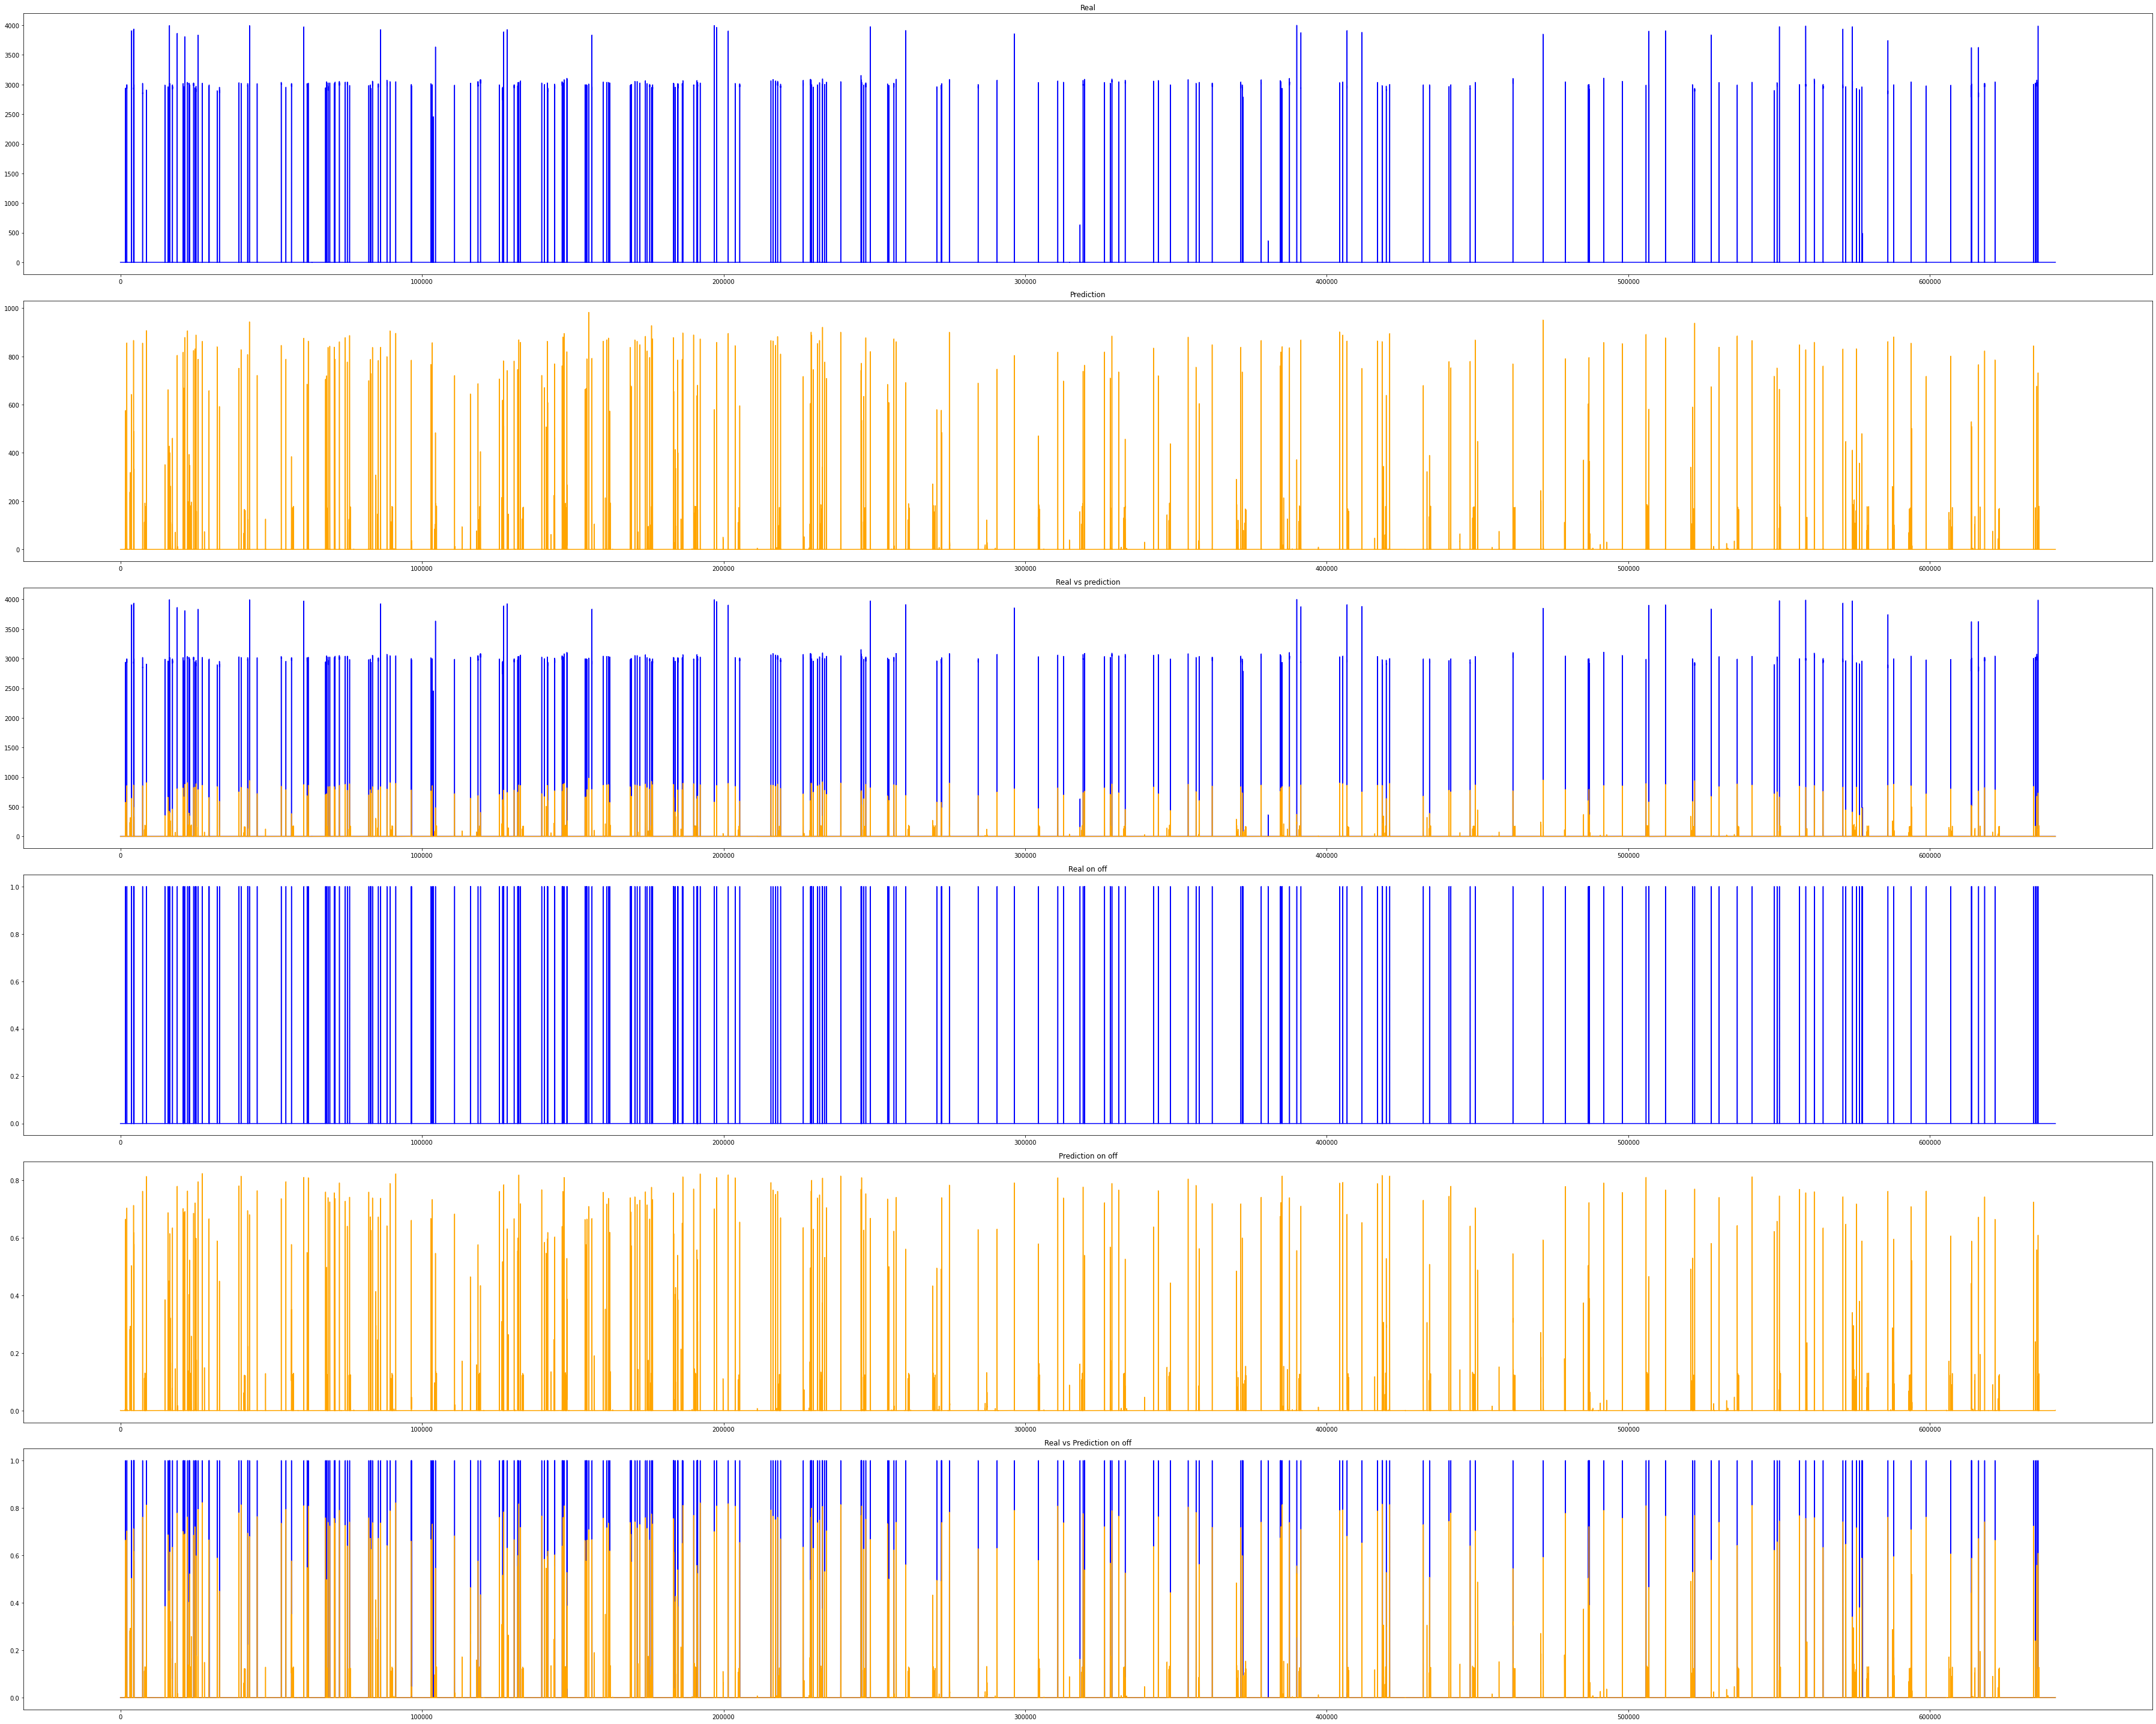

<Figure size 432x288 with 0 Axes>

In [19]:
# Test
appliance_test_classification = np.copy(appliance_test)
appliance_test_classification[appliance_test_classification <= THRESHOLD] = 0
appliance_test_classification[appliance_test_classification > THRESHOLD] = 1

appliance_min_power = np.min(appliance_train)
appliance_max_power = np.max(appliance_train)

main_test = standardize_data(main_test, np.mean(main_test), np.std(main_test))

appliance_test_regression = np.copy(appliance_test)
appliance_test_regression = normalize_data(appliance_test_regression, appliance_min_power, appliance_max_power)

batch_size = 32

test_generator = DataGenerator(main_test, appliance_test_regression,
                                    appliance_test_classification, window_size, batch_size)

test_steps = test_generator.__len__()

      
predicted_output, predicted_on_off = model.predict(x=test_generator, steps=test_steps) 
predicted_output *= (appliance_max_power - appliance_min_power)
predicted_output += appliance_min_power
 # Clip negative values to zero
predicted_output[predicted_output < 0] = 0.0

prediction = build_overall_sequence(predicted_output)
prediction_on_off = build_overall_sequence(predicted_on_off)

# Compute metrics
N = 1200
MAE = mae(prediction, appliance_test)
SAE_std = abs(np.sum(appliance_test, dtype=np.int64) - np.sum(prediction, dtype=np.int64)) / np.sum(appliance_test, dtype=np.int64)
                                                                                                      
SAE = sae(prediction, appliance_test, N=N)
F1 = f1(prediction_on_off, appliance_test_classification)

print("MAE = {}".format(MAE))
print("SAE = {}".format(SAE))
print("SAE_std = {}".format(SAE_std))
print("F1 = {}".format(F1))

# Plot the result of the prediction
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(50, 40))
axes[0].set_title("Real")
axes[0].plot(np.arange(len(appliance_test)), appliance_test, color='blue')
axes[1].set_title("Prediction")
axes[1].plot(np.arange(len(prediction)), prediction, color='orange')
axes[2].set_title("Real vs prediction")
axes[2].plot(np.arange(len(appliance_test)), appliance_test, color='blue')
axes[2].plot(np.arange(len(prediction)), prediction, color='orange')
axes[3].set_title("Real on off")
axes[3].plot(np.arange(len(appliance_test_classification)), appliance_test_classification, color='blue')
axes[4].set_title("Prediction on off")
axes[4].plot(np.arange(len(prediction_on_off)), prediction_on_off, color='orange')
axes[5].set_title("Real vs Prediction on off")
axes[5].plot(np.arange(len(appliance_test_classification)), appliance_test_classification, color='blue')
axes[5].plot(np.arange(len(prediction_on_off)), prediction_on_off, color='orange')
fig.tight_layout()
plt.show()
plt.savefig(appliance + '.png')